#### Beta Mixture Model Hidden Markov Model (BMM-HMM)

This notebook provides examples of fitting BMM-HMM model variants:
1. single-session BMM-HMM
2. oracle BMM-HMM
3. multi-session BMM-HMM

In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pymc3 as pm
from hmmlearn import vhmm
from scipy.stats import pointbiserialr
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

path_root = '../src'
sys.path.append(str(path_root))

from models.BMM_HMM import (
    BMM_HMM, HMM, Oracle_BMM_HMM, BetaProcess, 
    Constrained_BMM_HMM, posterior_inference
)
from utils.viz_utils import (
    plot_multi_session_hmm_results, 
    plot_bmm_hmm_results
)
seed = 42

#### LOAD DATA
We retrieve pre-computed decoder outputs from previously fitted single-session models. Alternatively, users can apply custom decoders to generate the required inputs for the BMM-HMM model:
1. `gt`: ground truth behavior over sequential trials in each session, e.g., binary choice `[0, 1, 1, 0, ...]`
2. `decoder_output`: single-session decoder output over sequential trials in each session, e.g., prob. estimate `[0.1, 0.9, 0.84, 0.05, ...]`

In [2]:
brain_region = "ca1"
behavior = "choice"
data_path = Path("../data/example_decoder_outputs")
pids = [pid for pid in os.listdir(data_path) if os.path.exists(data_path/pid/behavior)]

In [3]:
gt_lst, decoder_output_lst = [], []

for _, pid in enumerate(pids):

    gt, decoder_output, trial_idx = [], [], []
    # Load data from 5 cross-validated folds
    for fold_idx in range(1,5+1):
        gt.append(
            np.load(
                data_path/pid/behavior/brain_region/"y_obs"/f"fold_{fold_idx}.npy", allow_pickle=True
            ).item()["thresholded"]
        )
        decoder_output.append(
            np.load(
                data_path/pid/behavior/brain_region/"y_prob"/f"fold_{fold_idx}.npy", allow_pickle=True
            ).item()["thresholded"]
        )
        trial_idx.append(
            np.load(
                data_path/pid/behavior/brain_region/"trial_idx"/f"fold_{fold_idx}.npy", allow_pickle=True
            )
        )
    sorted_trial_idx = np.argsort(np.concatenate(trial_idx))
    gt = np.concatenate(gt)[sorted_trial_idx].reshape(-1,1)
    decoder_output = np.concatenate(decoder_output)[sorted_trial_idx].T[1].reshape(-1,1)
    gt_lst.append(gt)
    decoder_output_lst.append(decoder_output)
    
gt_lst = np.array(gt_lst, dtype=object)
decoder_output_lst = np.array(decoder_output_lst, dtype=object)

#### SINGLE-SESSION BMM-HMM
This model learns parameters only from `decoder_output` in the test session. 

In [4]:
test_idx = 9
test_pid = pids[test_idx] # example
test_decoder_output = decoder_output_lst[test_idx].squeeze()
test_gt = gt_lst[test_idx].squeeze()
print(f"Apply BMM-HMM to improve decoder outputs from region {brain_region} and session {test_pid}.")

Apply BMM-HMM to improve decoder outputs from region ca1 and session 523f8301-4f56-4faf-ab33-a9ff11331118.


In [37]:
# Initialize BMM-HMM
states = [0, 1, 2]
init_pi = {0: np.log(0.2), 1:np.log(0.4), 2: np.log(0.4)}
init_a = {
        0: {0: np.log(.9), 1: np.log(.05), 2: np.log(.05)},
        1: {0: np.log(.05), 1: np.log(.9), 2: np.log(.05)},
        2: {0: np.log(.05), 1: np.log(.05), 2: np.log(.9)} }
init_phi = {
        0: {0: np.log(.6), 1: np.log(.4)},
        1: {0: np.log(.9), 1: np.log(.1)},
        2: {0: np.log(.1), 1: np.log(.9)}
         }
init_beta_a = [3, 1]
init_beta_b = [1, 3]

# Fit BMM-HMM
bmm_hmm = BMM_HMM(
    test_decoder_output, init_pi, init_a, init_phi, init_beta_a, init_beta_b, tol=1e-1
)
bmm_hmm.update(test_decoder_output)

# Posterior inference
a_hat, phi_hat, beta_a_hat, beta_b_hat = bmm_hmm.a, bmm_hmm.phi, bmm_hmm.beta_a, bmm_hmm.beta_b
single_sess_A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)
single_sess_B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(test_decoder_output)])
states = np.exp(states)
states = states / states.sum(1).reshape(-1,1)
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
single_sess_preds, single_sess_probs = posterior_inference(bmm_hmm, test_decoder_output)

print('-------------------')
print('Original decoding accuracy (before single-session BMM-HMM): ', roc_auc_score(test_gt, test_decoder_output))
print('Improved decoding accuracy (after single-session BMM-HMM): ', roc_auc_score(test_gt, single_sess_probs))

BMM Convergence Achieved: True
log-likelihood: 79.59998853039822
BMM Convergence Achieved: True
log-likelihood: 96.4849259227508
BMM Convergence Achieved: True
log-likelihood: 103.95909944129266
BMM Convergence Achieved: True
log-likelihood: 106.9391448641759
BMM Convergence Achieved: True
log-likelihood: 108.0364736866424
BMM Convergence Achieved: True
log-likelihood: 108.33868974493117
BMM Convergence Achieved: True
log-likelihood: 108.46015034776171
BMM Convergence Achieved: True
log-likelihood: 108.74043894460301
BMM Convergence Achieved: True
log-likelihood: 108.81151984047506
-------------------
Original decoding accuracy (before single-session BMM-HMM):  0.6991670749632533
Improved decoding accuracy (after single-session BMM-HMM):  0.7176517749766157


#### ORACLE BMM-HMM
This model learns parameters only from `gt` in the test session ("Oracle" means that we have access to the ground truth). 

In [6]:
# Initialize HMM
p = [init_pi, init_a, init_phi]

# Fit HMM on ground truth
hmm = HMM(p)
hmm.update(test_gt, 1e-5)

oracle_states = np.array([np.array(list(state.values())) for state in hmm.forward(test_gt)])
oracle_states = np.exp(oracle_states)
oracle_states = oracle_states / oracle_states.sum(1)[:,None]

a_hat = hmm.forward_backward(test_gt)[1]
b_hat = hmm.forward_backward(test_gt)[2]
oracle_A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)
oracle_B = np.exp(
    [[b_hat[0][0], b_hat[0][1]], 
     [b_hat[1][0], b_hat[1][1]],
     [b_hat[2][0], b_hat[2][1]]]
)

# Fit BMM on ground truth
with pm.Model() as beta_model:
    alpha = pm.Exponential("a", 1, shape = 2)
    beta = pm.Exponential("b", 1, shape = 2)
    dk = BetaProcess('d', test_gt, alpha, beta, observed=test_decoder_output)
    step = pm.NUTS()     
    trace = pm.sample(
        draws=1000, step=step, chains=2, progressbar=True, 
        return_inferencedata=False, compute_convergence_checks=False
    )  
    beta_ppc = pm.sample_posterior_predictive(
        trace, var_names=["a", "b", "d"], random_seed=seed
    )
a0, a1 = beta_ppc["a"].mean(0)
b0, b1 = beta_ppc["b"].mean(0)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [7]:
# Initialize BMM-HMM
A, B = oracle_A, oracle_B
init_pi = {0:hmm.pi[0], 1:hmm.pi[1], 2:hmm.pi[2]}
init_a = {
    0: {0: np.log(A[0][0]), 1: np.log(A[0][1]), 2: np.log(A[0][2])},
    1: {0: np.log(A[1][0]), 1: np.log(A[1][1]), 2: np.log(A[1][2])},
    2: {0: np.log(A[2][0]), 1: np.log(A[2][1]), 2: np.log(A[2][2])} 
}
init_phi = {
    0: {0: np.log(B[0][0]), 1: np.log(B[0][1])},
    1: {0: np.log(B[1][0]), 1: np.log(B[1][1])},
    2: {0: np.log(B[2][0]), 1: np.log(B[2][1])}
}
init_beta_a, init_beta_b = [a1, a0], [b1, b0]

# Fit BMM-HMM
bmm_hmm = Oracle_BMM_HMM(
    test_decoder_output, init_pi, init_a, init_phi, init_beta_a, init_beta_b, tol=1e-1
)
bmm_hmm.update(test_decoder_output)

# Posterior inference
a_hat, phi_hat, beta_a_hat, beta_b_hat = bmm_hmm.a, bmm_hmm.phi, bmm_hmm.beta_a, bmm_hmm.beta_b
A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)
B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(test_decoder_output)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
oracle_preds, oracle_probs = posterior_inference(bmm_hmm, test_decoder_output)

print('-------------------')
print('Original decoding accuracy (before oracle BMM-HMM): ', roc_auc_score(test_gt, test_decoder_output))
print('Improved decoding accuracy (after oracle BMM-HMM): ', roc_auc_score(test_gt, oracle_probs))

-------------------
Original decoding accuracy (before oracle BMM-HMM):  0.6991670749632533
Improved decoding accuracy (after oracle BMM-HMM):  0.7709233441717518


#### Multi-Session BMM-HMM
This model learns parameters from `gt` in multiple training sessions and then uses such empirical prior information to fit a new BMM-HMM on `decoder_output` in the test session for inference. 

In [8]:
# Prepare training and test data
train_idxs = np.delete(np.arange(len(pids)), test_idx)
train_gt, test_gt = gt_lst[train_idxs], gt_lst[test_idx]
train_decoder_output = decoder_output_lst[train_idxs]
concat_train_gt = np.concatenate(train_gt)
lengths = [len(train_gt[idx]) for idx in range(len(train_gt))]

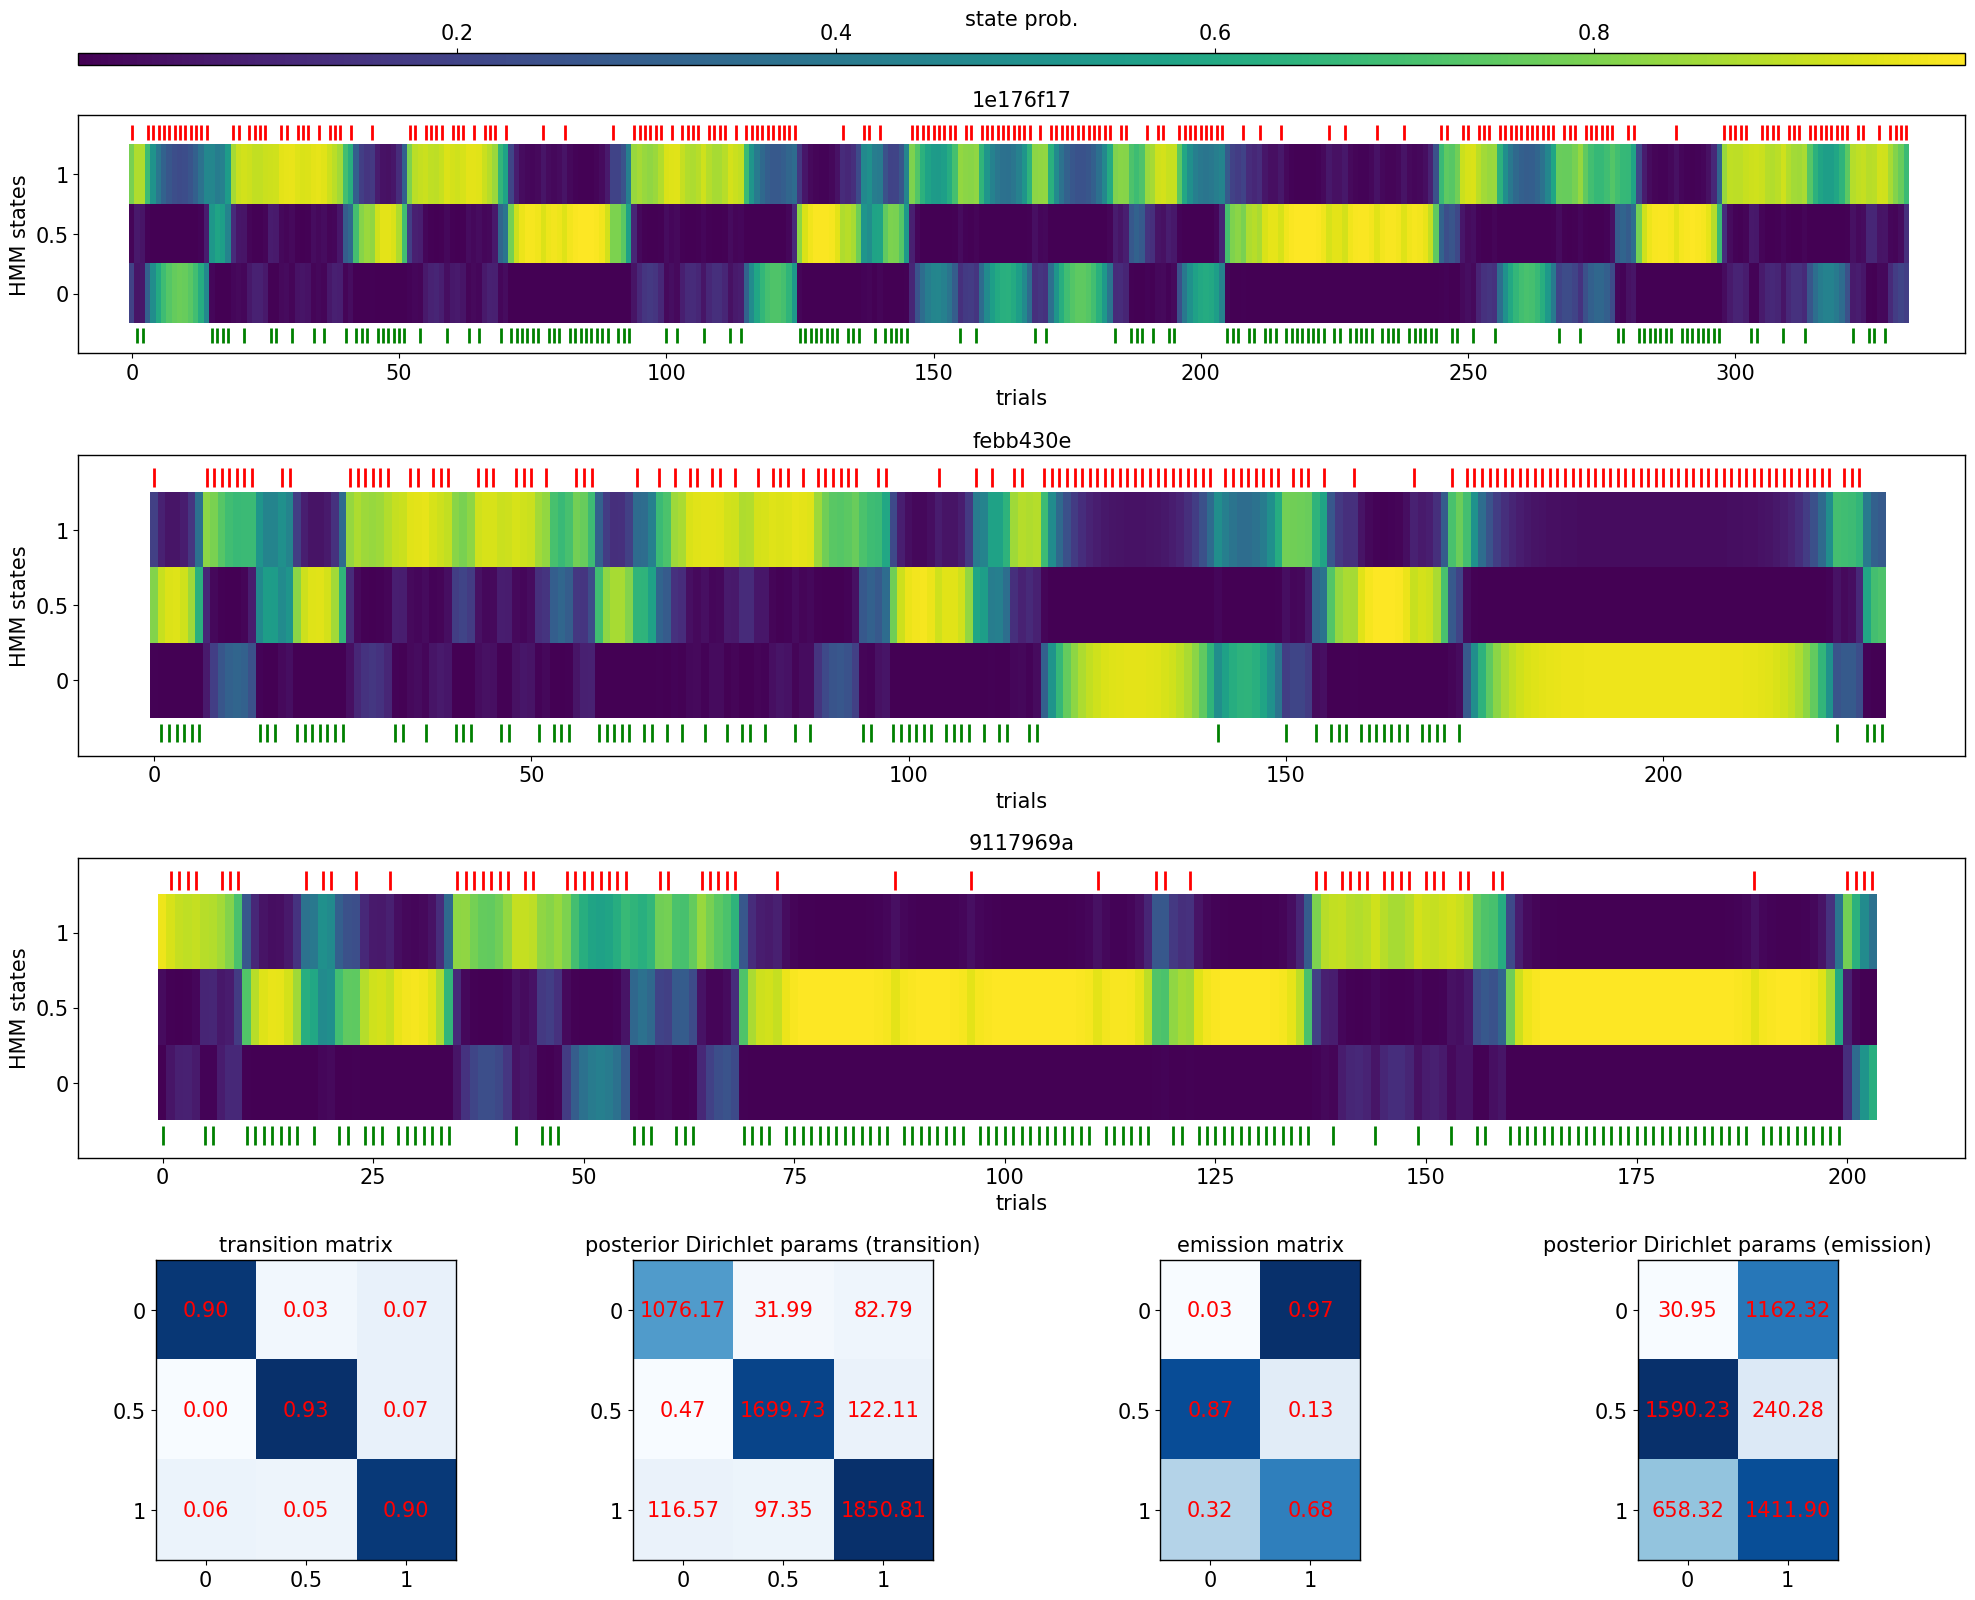

In [31]:
# Fit variational HMM (VHMM) on training sessions
multi_sess_hmm = vhmm.VariationalCategoricalHMM(n_components=3)
multi_sess_hmm.fit(concat_train_gt, lengths)

concat_train_states = multi_sess_hmm.predict_proba(concat_train_gt)
concat_trial_idxs = np.cumsum([0]+lengths)
train_states = [
    concat_train_states[concat_trial_idxs[i-1]:concat_trial_idxs[i]] \
    for i in range(1, len(concat_trial_idxs))
]
a_constraint, b_constraint = multi_sess_hmm.transmat_, multi_sess_hmm.emissionprob_
pi_posterior = multi_sess_hmm.startprob_posterior_
a_posterior = multi_sess_hmm.transmat_posterior_ 
b_posterior = multi_sess_hmm.emissionprob_posterior_

"""MODEL FITTING CHECK
NOTE: Make sure the state prob. heatmap looks like below before proceeding to next steps
      You can re-run vhmm a few times (random) until you get the desired outcomes
"""
plot_multi_session_hmm_results(
    states=train_states,
    choices=train_gt,
    pids=np.array(pids)[train_idxs],
    params=(a_constraint, b_constraint, a_posterior, b_posterior)
)

In [32]:
# Fit BMM on training sessions
_train_decoder_output = np.vstack(train_decoder_output).squeeze()
_train_gt = np.vstack(train_gt).squeeze()

with pm.Model() as beta_model:
    eta = pm.Gamma("eta", alpha = 5, beta = 1, shape = 2)
    nu = pm.Gamma("nu", alpha = 1, beta = 5, shape = 2)
    alpha = pm.Exponential("a", eta, shape = 2)
    beta = pm.Exponential("b", nu, shape = 2)
    dk = BetaProcess('d', _train_gt, alpha, beta, observed=_train_decoder_output)
    step = pm.NUTS()     
    trace = pm.sample(
        draws=1000, step=step, chains=2, progressbar=True,
        return_inferencedata=False, compute_convergence_checks=False
    )  
    beta_ppc = pm.sample_posterior_predictive(
        trace, var_names=["a", "b", "d", "eta", "nu"], random_seed=seed
    )
a0, a1 = beta_ppc["a"].mean(0)
b0, b1 = beta_ppc["b"].mean(0)
a0_prior, a1_prior = beta_ppc["eta"].mean(0)
b0_prior, b1_prior = beta_ppc["nu"].mean(0)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a, nu, eta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.


In [33]:
# Initialize BMM-HMM with empirical prior information
startprob, pi_prior = multi_sess_hmm.startprob_, multi_sess_hmm.startprob_posterior_
a_prior, phi_prior = multi_sess_hmm.transmat_posterior_, multi_sess_hmm.emissionprob_posterior_

init_pi = {0: np.log(startprob[0]), 1:np.log(startprob[1]), 2: np.log(startprob[2])}
init_a = {
        0: {0: np.log(a_constraint[0][0]), 1: np.log(a_constraint[0][1]), 2: np.log(a_constraint[0][2])},
        1: {0: np.log(a_constraint[1][0]), 1: np.log(a_constraint[1][1]), 2: np.log(a_constraint[1][2])},
        2: {0: np.log(a_constraint[2][0]), 1: np.log(a_constraint[2][1]), 2: np.log(a_constraint[2][2])} }
init_phi = {
        0: {0: np.log(b_constraint[0][0]), 1: np.log(b_constraint[0][1])},
        1: {0: np.log(b_constraint[1][0]), 1: np.log(b_constraint[1][1])},
        2: {0: np.log(b_constraint[2][0]), 1: np.log(b_constraint[2][1])}
         }
init_beta_a, init_beta_b = [a1, a0], [b1, b0]
beta_a_prior, beta_b_prior = [a1_prior, a0_prior], [b1_prior, b0_prior]

In [34]:
# Fit constrained BMM-HMM on the test session
bmm_hmm = Constrained_BMM_HMM(
    test_decoder_output, 
    init_pi, 
    init_a, 
    init_phi, 
    init_beta_a, 
    init_beta_b, 
    pi_prior, 
    a_prior, 
    phi_prior,
    beta_a_prior, 
    beta_b_prior,
    tol=1e-1
)
bmm_hmm.update(test_decoder_output)

# Posterior inference
a_hat, phi_hat, beta_a_hat, beta_b_hat = bmm_hmm.a, bmm_hmm.phi, bmm_hmm.beta_a, bmm_hmm.beta_b
multi_sess_A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)
multi_sess_B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)
states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(test_decoder_output)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
multi_sess_preds, multi_sess_probs = posterior_inference(bmm_hmm, test_decoder_output)

print('-------------------')
print('Original decoding accuracy (before multi-session BMM-HMM): ', roc_auc_score(test_gt, test_decoder_output))
print('Improved decoding accuracy (after multi-session BMM-HMM): ', roc_auc_score(test_gt, multi_sess_probs))

BMM Convergence Achieved:  True
log-likelihood: 102.13279339912354
BMM Convergence Achieved:  True
log-likelihood: 103.23771496105263
BMM Convergence Achieved:  True
log-likelihood: 103.69098553528585
BMM Convergence Achieved:  True
log-likelihood: 103.58043821000622
-------------------
Original decoding accuracy (before multi-session BMM-HMM):  0.6991670749632533
Improved decoding accuracy (after multi-session BMM-HMM):  0.7776936439356822


**NOTE:** The above example shows that the multi-session BMM-HMM performed even better than the oracle BMM-HMM which has access to the ground truth behavior.

#### Visualization

In [35]:
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 10
BIGGER_SIZE = 10
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.5)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=BIGGER_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 3

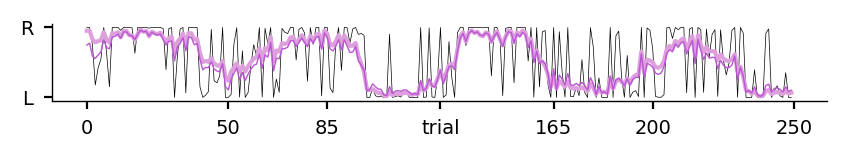

In [38]:
# Visualization of improved decoder outputs

fig, ax = plt.subplots(1,1,figsize=(5,.5))
ax.plot(single_sess_probs[:250], color="k", linewidth=.25, label="single-session")
ax.plot(oracle_probs[:250], color="plum", linewidth=1.5, label="oracle")
ax.plot(multi_sess_probs[:250], color="mediumorchid", linewidth=.5, label="multi-session")
ax.set_yticks([0, 1], ["L", "R"], fontsize=7)
ax.set_xticks([0, 50, 85, 125, 165, 200, 250], [0, 50, 85, "trial", 165, 200, 250], fontsize=7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

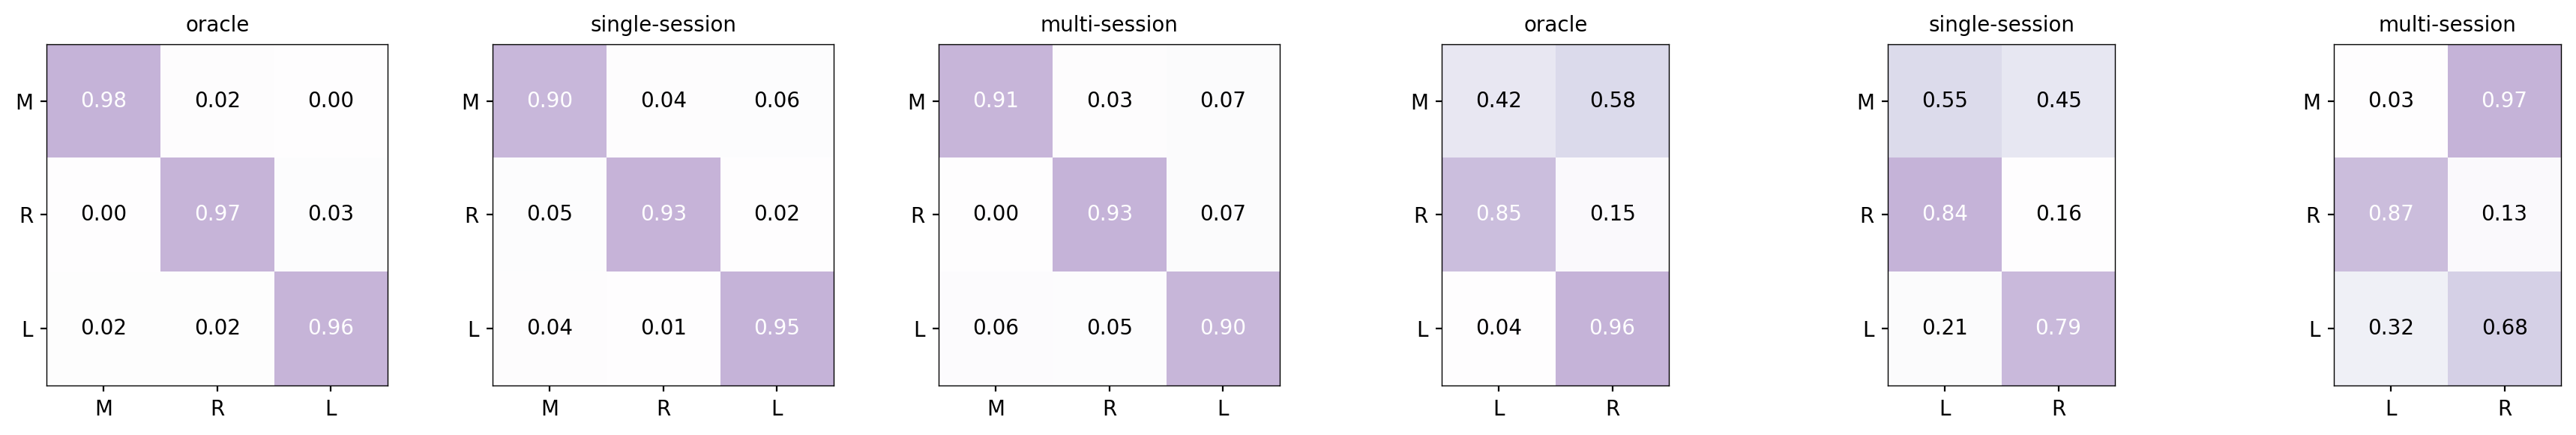

In [39]:
# Visualization of BMM-HMM model parameters

fig, axes = plt.subplots(1, 6, figsize=(18,3))
axes[0].imshow(oracle_A, cmap='Purples', alpha=.3)
axes[0].set_xticks([0,1,2], ["M", "R", "L"])
axes[0].set_yticks([0,1,2], ["M", "R", "L"])
axes[0].set_title("oracle")

for i in range(oracle_A.shape[0]):
    for j in range(oracle_A.shape[1]):
        if i == j:
            axes[0].text(j, i, f'{oracle_A[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[0].text(j, i, f'{oracle_A[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[1].imshow(single_sess_A, cmap='Purples', alpha=.3)
axes[1].set_xticks([0,1,2], ["M", "R", "L"])
axes[1].set_yticks([0,1,2], ["M", "R", "L"])
axes[1].set_title("single-session")

for i in range(single_sess_A.shape[0]):
    for j in range(single_sess_A.shape[1]):
        if i == j:
            axes[1].text(j, i, f'{single_sess_A[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[1].text(j, i, f'{single_sess_A[i, j]:.2f}', ha='center', va='center', color='k')
            
            
axes[2].imshow(multi_sess_A, cmap='Purples', alpha=.3)
axes[2].set_xticks([0,1,2], ["M", "R", "L"])
axes[2].set_yticks([0,1,2], ["M", "R", "L"])
axes[2].set_title("multi-session")

for i in range(multi_sess_A.shape[0]):
    for j in range(multi_sess_A.shape[1]):
        if i == j:
            axes[2].text(j, i, f'{multi_sess_A[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[2].text(j, i, f'{multi_sess_A[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[3].imshow(oracle_B, cmap='Purples', alpha=.3)
axes[3].set_xticks([0,1], ["L", "R"])
axes[3].set_yticks([0,1,2], ["M", "R", "L"])
axes[3].set_title("oracle")

for i in range(oracle_B.shape[0]):
    for j in range(oracle_B.shape[1]):
        if oracle_B[i, j] > 0.7:
            axes[3].text(j, i, f'{oracle_B[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[3].text(j, i, f'{oracle_B[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[4].imshow(single_sess_B, cmap='Purples', alpha=.3)
axes[4].set_xticks([0,1], ["L", "R"])
axes[4].set_yticks([0,1,2], ["M", "R", "L"])
axes[4].set_title("single-session")

for i in range(single_sess_B.shape[0]):
    for j in range(single_sess_B.shape[1]):
        if single_sess_B[i, j] > 0.7:
            axes[4].text(j, i, f'{single_sess_B[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[4].text(j, i, f'{single_sess_B[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[-1].imshow(multi_sess_B, cmap='Purples', alpha=.3)
axes[-1].set_xticks([0,1], ["L", "R"])
axes[-1].set_yticks([0,1,2], ["M", "R", "L"])
axes[-1].set_title("multi-session")

for i in range(multi_sess_B.shape[0]):
    for j in range(multi_sess_B.shape[1]):
        if multi_sess_B[i, j] > 0.7:
            axes[-1].text(j, i, f'{multi_sess_B[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[-1].text(j, i, f'{multi_sess_B[i, j]:.2f}', ha='center', va='center', color='k')
            
plt.tight_layout()